Notebook 4: In which we use neural networks to clasify handwritten digits
------------------------------------------------------------------------------------------
We will download MNIST, a popular easy benchmark for neural networks. 

In [13]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from typing import Callable, Literal
from tqdm.notebook import tqdm

from copy import copy

The problem we will be working with today will be a bit more complex, so we are interested in using the GPU if it is available. We will create a DEVICE constant that will store "cuda" only if CUDA compute is available. This code will work whether the GPU is available or not, and will use the GPU when it can do so.

In [2]:
def set_device() -> Literal["cpu"] | Literal["cuda"]:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device != "cuda":
        print("WARNING: GPU is not enabled in this environment.")
    else:
        print("GPU is enabled.")
    return device


DEVICE = set_device()

GPU is enabled.


MNIST is one of the datasets available through the torchvision library.

In [3]:
def load_mnist_data(download=True) -> tuple[datasets.MNIST, datasets.MNIST]:
    tform = transforms.Compose([transforms.ToTensor()])
    train_set = datasets.MNIST(root=".", train=True, download=download, transform=tform)
    test_set = datasets.MNIST(root=".", train=False, transform=tform)
    return train_set, test_set

In [4]:
try:
    train_set, test_set = load_mnist_data(download=False)
except RuntimeError:
    train_set, test_set = load_mnist_data(download=True)

Let's get some additional information on the dataset.

In [7]:
print("Number of images in training and their size:", train_set.data.shape)
print(
    f"Type {train_set.data.dtype}, range {train_set.data.min()}-{train_set.data.max()}"
)
print("Number of training labels", len(train_set.targets))
print("Labels are", train_set.targets)

Number of images in training and their size: torch.Size([60000, 28, 28])
Type torch.uint8, range 0-255
Number of training labels 60000
Labels are tensor([5, 0, 4,  ..., 5, 6, 8])


Images need to be in float type to be usable by the networks.

In [6]:
train_set.data = train_set.data.float()
test_set.data = test_set.data.float()

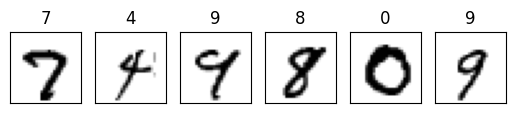

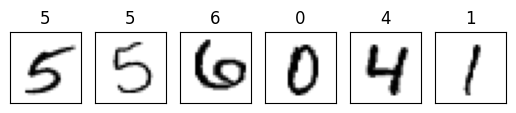

In [8]:
def show_images(images, labels):
    fig, axes = plt.subplots(1, len(images))
    for image, label, ax in zip(images, labels, axes):
        ax.imshow(image, cmap="gray_r")
        ax.set(xticks=(), yticks=(), title=label.item())


show_images(train_set.data[52:58], train_set.targets[52:58])
show_images(test_set.data[52:58], test_set.targets[52:58])

We have training and test data. Our pipeline requires a validation data. We will split the original 60,000 examples in training into 50,000 training and 10,000 validation. Then, we reshape them to use them with a linear network.

In [9]:
validation_set = copy(train_set)
train_set.data = train_set.data[:50000]
train_set.targets = train_set.targets[:50000]
validation_set.data = validation_set.data[50000:]
validation_set.targets = validation_set.targets[50000:]

print(
    "New shapes: ",
    [d.shape for d in [train_set.data, validation_set.data, test_set.data]],
)

New shapes:  [torch.Size([50000, 28, 28]), torch.Size([10000, 28, 28]), torch.Size([10000, 28, 28])]


To better use in training, we put the datasets into a dataloader and define a batch size.

In [10]:
def get_data_loaders(train_dataset, validation_dataset, test_dataset, batch_size=128):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(
        validation_dataset, batch_size=batch_size, shuffle=True
    )
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, validation_loader, test_loader


train_loader, validation_loader, test_loader = get_data_loaders(
    train_set, validation_set, test_set
)

We now design the network.

In [11]:
class MNISTLinearNetwork(nn.Module):
    def __init__(
        self,
        number_inputs: int = 28 * 28,
        number_hidden: int = 512,
        number_outputs: int = 10,
    ):
        super().__init__()

        self.number_inputs = number_inputs
        self.number_hidden = number_hidden
        self.number_outputs = number_outputs

        self.layer1 = nn.Sequential(
            nn.Linear(in_features=self.number_inputs, out_features=self.number_hidden),
            nn.Sigmoid(),
        )

        self.layer2 = nn.Sequential(
            nn.Linear(in_features=self.number_hidden, out_features=self.number_outputs),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(-1, self.number_inputs)  # Our network expects vectors as input
        x = self.layer1(x)
        x = self.layer2(x)

        return x

As in the previous notebook, we need to define the training loop. Small changes are made compared to what we have already seen since we are using a dataloader.

In [16]:
def train_loop(
    model: nn.Module,
    epochs: int,
    optimizer: torch.optim.Optimizer,
    train_loader: DataLoader,
    validation_loader: DataLoader,
    loss_fn: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
    device: str | torch.device,
) -> tuple[list[float], list[float], list[float], list[float]]:
    train_loss: list[float] = []
    train_acc: list[float] = []
    val_loss: list[float] = []
    val_acc: list[float] = []

    with tqdm(range(epochs), unit="epoch") as tepochs:
        tepochs.set_description("Training")
        for epoch in tepochs:
            running_loss = 0.0
            correct, total = 0, 0

            model.train()
            # Train on a batch of images
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                output = model(images)
                optimizer.zero_grad()
                loss = loss_fn(output, labels)
                loss.backward()
                optimizer.step()

                tepochs.set_postfix(loss=loss.item())
                running_loss += loss.item()

                # get accuracy
                _, predicted = torch.max(output, dim=1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            # append the loss for this epoch (running loss divided by the number of batches e.g. len(train_loader))
            train_loss.append(running_loss / len(train_loader))
            train_acc.append(correct / total)

            model.eval()
            # Loss and accuracy for validation dataset
            for images, labels in validation_loader:
                images, labels = images.to(device), labels.to(device)

                output = model(images)
                loss = loss_fn(output, labels)

                running_loss += loss.item()

                _, predicted = torch.max(output, dim=1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            # append the loss for this epoch (running loss divided by the number of batches e.g. len(train_loader))
            val_loss.append(running_loss / len(train_loader))
            val_acc.append(correct / total)

    return train_loss, train_acc, val_loss, val_acc

Fitting network to data

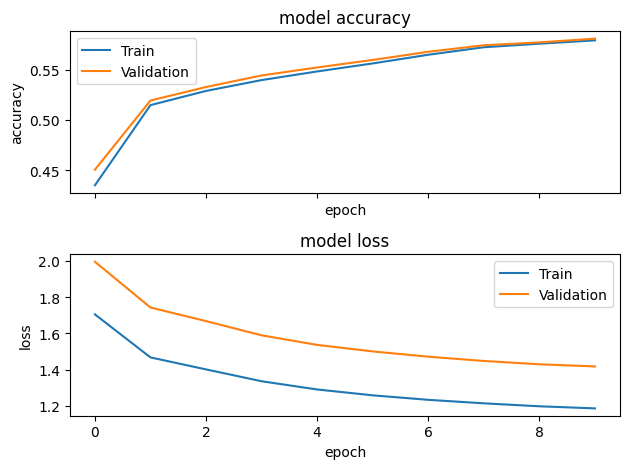

In [17]:
mnist_network = MNISTLinearNetwork().to(DEVICE)
# optimizer = torch.optim.SGD(
#     mnist_network.parameters(), lr=0.001, weight_decay=1e-6, momentum=0.9, nesterov=True
# )
optimizer = torch.optim.RMSprop(
    mnist_network.parameters(), lr=0.001, alpha=0.9, weight_decay=0.0
)
loss_fn = nn.CrossEntropyLoss()

train_loss, train_acc, val_loss, val_acc = train_loop(
    mnist_network,
    epochs=10,
    optimizer=optimizer,
    train_loader=train_loader,
    validation_loader=validation_loader,
    loss_fn=loss_fn,
    device=DEVICE,
)

# summarize history for accuracy
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.plot(train_acc, label="Train")
ax1.plot(val_acc, label="Validation")
ax1.set(title="model accuracy", ylabel="accuracy", xlabel="epoch")
ax1.legend()

# summarize history for loss
ax2.plot(train_loss, label="Train")
ax2.plot(val_loss, label="Validation")
ax2.set(title="model loss", ylabel="loss", xlabel="epoch")
ax2.legend()

fig.tight_layout()

Let us write a short function to compute the accuracy on the test set.

In [18]:
def test(model: MNISTLinearNetwork, data_loader: DataLoader, device):
    model.eval()
    correct = 0
    total = 0
    for data in data_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model.forward(inputs)
        _, predicted = outputs.max(dim=1)
        total += len(labels)
        correct += torch.count_nonzero(predicted == labels)

    return correct / total


accuracy = test(mnist_network, test_loader, DEVICE)

In [19]:
print(f"The model has a test accuracy of {accuracy:.2%}")

The model has a test accuracy of 58.48%


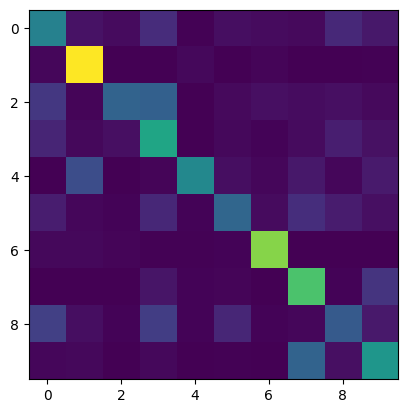

In [20]:
from sklearn.metrics import confusion_matrix


def network_confusion_matrix(
    model: MNISTLinearNetwork, data_loader: DataLoader, device
):
    model.eval()
    predictions = torch.tensor([]).to(device)
    true_values = torch.tensor([]).to(device)

    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model.forward(inputs)
        _, predicted = outputs.max(dim=1)

        predictions = torch.cat((predictions, predicted))
        true_values = torch.cat((true_values, labels))

    confusion = confusion_matrix(true_values.cpu(), predictions.cpu())
    plt.imshow(confusion)


network_confusion_matrix(mnist_network, test_loader, DEVICE)

**Ex 1:** The range of inputs to the network is very important, and should roughly be similar to random weight initialisation. One possibly way to go about this would be to normalise pixels between 0 and 1 by changing the lines: 

    train_set.data = train_set.data.float()
    test_set.data = test_set.data.float()

for:

    train_set.data = train_set.data / 255
    test_set.data = test_set.data / 255

and restart the notebok (Kernel > Restart & Run all). Accuracy should improve faster! See if you can improve it even more by normalising the dataset to have mean 0 and std 1.
Even better, we could normalise the dataset to have mean 0 and std 1, as quite ofthen neural network weights are initialised by taking samples from a normal distribution with those parameters. Note that the parameters used to normalise should be computed using only the information of the training set, to avoid introducing information of the test set into training. As such, the proper way to go about this is to compute the mean and std of the training samples and use those values to normalise both the training and test images.

    train_set_mean, train_set_std = torch.mean(train_set.data.float()), torch.mean(train_set.data.float())
    train_set.data = (train_set.data - train_set_mean) / train_set_std
    test_set.data = (test_set.data - train_set_mean) / train_set_std

Normalisation can be handled via a transform when loading the dataset, see the documentation for

    transforms.Normalize

Namely, in the mnist loading function the line

``` python
tform = transforms.Compose([transforms.ToTensor()])
```

could be changed to

    tform = transforms.Compose([transforms.ToTensor(),
                                            transforms.Normalize((0,), (1,))
                                            ])

**Ex 2:** Explore the effect of changing the network architecture (Number of layers and number of neurons). If you identify overfitting, use EarlyStopping as in the previous notebook.

**Ex 3** (advanced): See how the performance of the network decreases when giving noisy and black-and-white versions of MNIST. You can use the following function:
    
    def threshold_with_noise(images, threshold = 0.5, noise_std = 0):
        noise = torch.rand(images.size()) * noise_std
        return torch.where(images + noise > threshold, 1.0, 0.0).float()